In [15]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt

print(tf.__version__)

NUM_WORDS = 10000
NUM_SAMPLE = 10000
reverse_word_index = None
train_data = None
train_labels = None
test_data = None
test_labels = None
history = None
baseline_history = None
smaller_history = None
bigger_history = None
l2_model_history = None
dpt_model_history = None

1.12.0


### Get data and create dictionary for word index

In [16]:
def loadDatasets():
    global train_data, train_labels, test_data, test_labels
    imdb = keras.datasets.imdb
    (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000, path=os.getcwd() + r"\datasets\imdb.npz")
    print("Training entries:{}, labels:{}".format(len(train_data), len(train_labels)))
    print("train_data.shape:{}\nlength of train_data[0]:{} length of train_data[1]:{}"
          .format(train_data.shape, len(train_data[0]), len(train_data[1])))
    
    global reverse_word_index
    # A dictionary mapping words to an integer index
    word_index = imdb.get_word_index(path=os.getcwd() + r"\datasets\imdb_word_index.json")

    # The first indices are reserved
    word_index = {k:(v+3) for k,v in word_index.items()}
    word_index["<PAD>"] = 0
    word_index["<START>"] = 1
    word_index["<UNK>"] = 2  # unknown
    word_index["<UNUSED>"] = 3

    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    
    train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                           value = word_index["<PAD>"],
                                                           padding = 'post',
                                                           maxlen = 256)
    test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [17]:
def multi_hot_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # set specific indices of results[i] to 1s
    return results

In [18]:
def restractOverFit():
    global train_data, test_data
    train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
    test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS) 
    plt.plot(train_data[0])

In [19]:
def decode_review(text):
    return ' '.join([reverse_word_index[i] for i in text])

In [20]:
def neualNetwork():
    global history
    vocab_size = 10000
    
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, 16))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dense(16, activation = tf.nn.relu))
    model.add(keras.layers.Dense(1, activation = tf.nn.sigmoid))
    model.compile(optimizer = tf.train.AdamOptimizer(),
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])
    model.summary()
    x_val = train_data[:10000]
    partial_x_train = train_data[10000:]
    y_val = train_labels[:10000]
    partial_y_train = train_labels[10000:]
    
    history = model.fit(partial_x_train,
                       partial_y_train,
                       epochs = 40,
                       batch_size =512,
                       validation_data = (x_val, y_val),
                       verbose =1)
    result = model.evaluate(test_data, test_labels)
    print(result)
    

In [21]:
def baseNN():
    global baseline_history
    baseline_model = keras.Sequential([
        # `input_shape` is only required here so that `.summary` works.
        keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
        keras.layers.Dense(16, activation=tf.nn.relu),
        keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])

    baseline_model.compile(optimizer='adam',
                           loss='binary_crossentropy',
                           metrics=['accuracy', 'binary_crossentropy'])

    baseline_model.summary()    

    baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

In [24]:
def smallerNN():
    global smaller_history
    smaller_model = keras.Sequential([
        keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
        keras.layers.Dense(4, activation=tf.nn.relu),
        keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])

    smaller_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'binary_crossentropy'])

    smaller_model.summary()    
    smaller_history = smaller_model.fit(train_data,
                                        train_labels,
                                        epochs=20,
                                        batch_size=512,
                                        validation_data=(test_data, test_labels),
                                        verbose=2)    

In [22]:
def biggerNN():
    global bigger_history
    bigger_model = keras.models.Sequential([
        keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
        keras.layers.Dense(512, activation=tf.nn.relu),
        keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])

    bigger_model.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['accuracy','binary_crossentropy'])

    bigger_model.summary()    
    bigger_history = bigger_model.fit(train_data, train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)


In [23]:
def L2NN():
    global l2_model_history
    l2_model = keras.models.Sequential([
        keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                           activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
        keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                           activation=tf.nn.relu),
        keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])

    l2_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy', 'binary_crossentropy'])

    l2_model_history = l2_model.fit(train_data, train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)    


In [25]:
def randomDropoutNN():
    global dpt_model_history
    dpt_model = keras.models.Sequential([
        keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(16, activation=tf.nn.relu),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])

    dpt_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy','binary_crossentropy'])

    dpt_model_history = dpt_model.fit(train_data, train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

In [26]:
def plot_history(histories, key='binary_crossentropy'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])


In [27]:
def drawTrade():
    import matplotlib.pyplot as plt
    global history
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.clf()   # clear figure
    acc_values = history.history['acc']
    val_acc_values = history.history['val_acc']

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

### Main()

Training entries:25000, labels:25000
train_data.shape:(25000,)
length of train_data[0]:218 length of train_data[1]:189
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 9s - loss: 0.6383 - acc: 0.6200 - binary_crossentropy: 0.6383 - val_loss: 0.5255 - val_acc: 0.8284 - val_binary_crossentropy: 0.5255
Epoch 2/20
 - 6s - loss: 0.4995 - acc: 0.7940 - binary_crossentropy: 0.4995 - val_loss: 0.4005 - val_acc: 0.8741 - val_binary_crossentropy: 0.4005
Epoch 3/20
 - 6s - loss: 0.3959 - acc: 0.8618 - binary_crossentropy: 0.3959 - val_loss: 0.3303 - val_acc: 0.8808 - val_binary_crossentropy: 0.3303
Epoch 4/20
 - 8s - loss: 0.3245 - acc: 0.8921 - binary_crossentropy: 0.3245 - val_loss: 0.3030 - val_acc: 0.8833 - val_binary_crossentropy: 0.3030
Epoch 5/20
 - 5s - loss: 0.2776 - acc: 0.9079 - binary_crossentropy: 0.2776 - val_loss: 0.2960 - val_acc: 0.8819 - val_binary_crossentropy: 0.2960
Epoch 6/20
 - 6s - loss: 0.2407 - acc: 0.9215 - binary_crossentropy: 0.2407 - val_loss: 0.3011 -

AttributeError: 'NoneType' object has no attribute 'epoch'

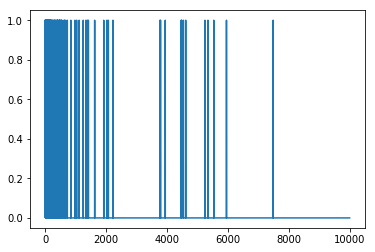

<Figure size 1152x720 with 0 Axes>

In [29]:
if __name__=='__main__':
    isPrepareDatasetsNeeded = True
    if isPrepareDatasetsNeeded:
        loadDatasets()
    restractOverFit()
    isTrainingNeeded = False
    if isTrainingNeeded:
        #neualNetwork()
        baseNN()
        smallerNN()
        biggerNN()
        L2NN()
        randomDropoutNN()        
        plot_history([('baseline', baseline_history),
                  ('smaller', smaller_history),
                  ('bigger', bigger_history),
                  ('l2', l2_model_history),
                  ('dropout', dpt_model_history)])                      
    #print(decode_review(train_data[0]))
    #drawTrade()
